In [12]:
import pandas as pd
import pandahouse as ph
import seaborn as sns
import matplotlib.pyplot as plt
import telegram
import io
from datetime import datetime, timedelta
plt.set_loglevel('WARNING')

connection = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'simulator_20220620',
                      'user':'student', 
                      'password':'dpo_python_2020'
             }


In [23]:
def extract_dau_yesterday(connection):
    query = """
    SELECT count(DISTINCT user_id) AS dau
    FROM simulator_20220620.feed_actions
    WHERE toDate(time) = today() - 1
    """
    result = ph.read_clickhouse(query, connection=connection)

    return result.dau[0]

def extract_views_yesterday(connection):
    query = """
    SELECT sum(action='view') AS views
    FROM simulator_20220620.feed_actions
    WHERE toDate(time) = today() - 1
    """
    result = ph.read_clickhouse(query, connection=connection)

    return result.views[0]


def extract_likes_yesterday(connection):
    query = """
    SELECT sum(action='like') AS likes
    FROM simulator_20220620.feed_actions
    WHERE toDate(time) = today() - 1
    """
    result = ph.read_clickhouse(query, connection=connection)

    return result.likes[0]

def extract_ctr_yesterday(connection):
    query = """
    SELECT round(sum(action='like')/sum(action='view'), 3) AS ctr
    FROM simulator_20220620.feed_actions
    WHERE toDate(time) = today() - 1
    """
    result = ph.read_clickhouse(query, connection=connection)

    return result.ctr[0]



def send_kpi_yesterday(chat_id, msg):
    bot.sendMessage(chat_id=chat_id, text=msg)


def extract_table_for_graph(connection):
    query = """
    SELECT toDate(time) AS event_date,
           count(DISTINCT user_id) AS dau,
           sum(action='view') AS views,
           sum(action='like') AS likes,
           sum(action='like') / sum(action='view') AS ctr
    FROM simulator_20220620.feed_actions
    WHERE toDate(time) >= today() - 7
      AND toDate(time) < today()
    GROUP BY toDate(time)
    """
    df = ph.read_clickhouse(query, connection=connection)
    df['event_date'] = df['event_date'].dt.strftime("%b-%d")

    return df

def send_graphs_last_7days(data):
    fig, ax = plt.subplots(2, 2, figsize=(16, 10))

    sns.set_style("darkgrid")

    sns.lineplot(ax=ax[0, 0], x='event_date', y='dau', data=table_for_graph)
    ax[0, 0].set_title("Тренд DAU ленты за последние 7 дней")
    ax[0, 0].set(xlabel=None)
    ax[0, 0].set(ylabel=None)

    sns.lineplot(ax=ax[1, 0], x='event_date', y='views', data=table_for_graph)
    ax[1, 0].set_title("Тренд Views за последние 7 дней")
    ax[1, 0].set(xlabel=None)
    ax[1, 0].set(ylabel=None)

    sns.lineplot(ax=ax[0, 1], x='event_date', y='likes', data=table_for_graph)
    ax[0, 1].set_title("Тренд Likes за последние 7 дней")
    ax[0, 1].set(xlabel=None)
    ax[0, 1].set(ylabel=None)

    sns.lineplot(ax=ax[1, 1], x='event_date', y='ctr', data=table_for_graph)
    ax[1, 1].set_title("Тренд CTR за последние 7 дней")
    ax[1, 1].set(xlabel=None)
    ax[1, 1].set(ylabel=None)

    plot_object = io.BytesIO()
    plt.savefig(plot_object)
    plot_object.seek(0)
    plot_object.name = 'daily_feed.png'
    plt.close()
    bot.sendPhoto(chat_id=chat_id, photo=plot_object)


def create_message(yesterday, dau_yesterday, views_yesterday, likes_yesterday, ctr_yesterday):
    msg = f'KPI Ленты за {yesterday}:\n\n👤 DAU:   {dau_yesterday}\n👀 Views: {views_yesterday}\n❤️  Likes: {likes_yesterday}\n📄 CTR:   {ctr_yesterday}'

    return msg

yesterday = (datetime.today() - pd.Timedelta(days=1)).strftime("%Y-%m-%d")

dau_yesterday = extract_dau_yesterday(connection)
views_yesterday = extract_views_yesterday(connection)
likes_yesterday = extract_likes_yesterday(connection)
ctr_yesterday = extract_ctr_yesterday(connection)

chat_id = 275002908
my_token = '5595853879:AAEMGPHw1eHFxetHl2dbEZ8tOiFVt0otJyk' 
bot = telegram.Bot(token=my_token)

msg = create_message(yesterday=yesterday, 
                     dau_yesterday=dau_yesterday, 
                     views_yesterday=views_yesterday, 
                     likes_yesterday=likes_yesterday, 
                     ctr_yesterday=ctr_yesterday)
#send_kpi_yesterday(chat_id=chat_id, msg=msg)

table_for_graph = extract_table_for_graph(connection)

#send_graphs_last_7days(data=table_for_graph)



## Пример сообщения


KPI Ленты за 2022-07-13:

👤 DAU:   18269
👀 Views: 608339
❤️  Likes: 121381
📄 CTR:   0.2


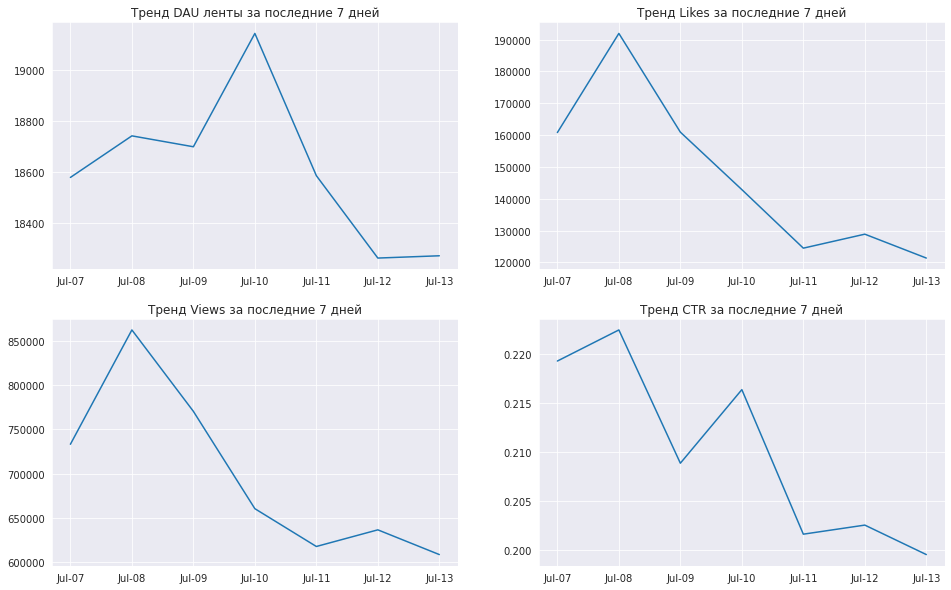

In [34]:
#пример графика 
fig, ax = plt.subplots(2, 2, figsize=(16, 10))

sns.set_style("darkgrid")

sns.lineplot(ax=ax[0, 0], x='event_date', y='dau', data=table_for_graph)
ax[0, 0].set_title("Тренд DAU ленты за последние 7 дней")
ax[0, 0].set(xlabel=None)
ax[0, 0].set(ylabel=None)

sns.lineplot(ax=ax[1, 0], x='event_date', y='views', data=table_for_graph)
ax[1, 0].set_title("Тренд Views за последние 7 дней")
ax[1, 0].set(xlabel=None)
ax[1, 0].set(ylabel=None)

sns.lineplot(ax=ax[0, 1], x='event_date', y='likes', data=table_for_graph)
ax[0, 1].set_title("Тренд Likes за последние 7 дней")
ax[0, 1].set(xlabel=None)
ax[0, 1].set(ylabel=None)

sns.lineplot(ax=ax[1, 1], x='event_date', y='ctr', data=table_for_graph)
ax[1, 1].set_title("Тренд CTR за последние 7 дней")
ax[1, 1].set(xlabel=None)
ax[1, 1].set(ylabel=None)

#Пример сообщения
print()
print(create_message(yesterday, dau_yesterday, views_yesterday, likes_yesterday, ctr_yesterday))